## Testing

In [113]:
import os
from elasticsearch import Elasticsearch
from piffle.iiif import IIIFImageClient 
from io import BytesIO
import httpx
from PIL import Image

In [114]:
local_es = Elasticsearch(
    hosts=os.environ['LOCAL_HOST'],
    http_auth=(
        os.environ['LOCAL_USER'],
        os.environ['LOCAL_PASS']
    )
)

In [115]:
response = local_es.search(
    index=os.environ['INDEX_NAME'],
    body={
        "query":{
            "match_all":{}
        },
        "size":20,
        "from":0,
        "sort":{
            "_id":"asc", #document ID. Unique(I guess)
        },
    }
)

In [116]:
print(
    f"Found {response['hits']['total']['value']} "
    f"results in {response['took'] / 1000}s"
)

Found 10000 results in 0.304s


It still gets 10000 results for each run. Can this be optimised?

In [117]:
#get the id for the last hit
last_result = response['hits']['hits'][19]
print(last_result['_id'])

a24se2bc


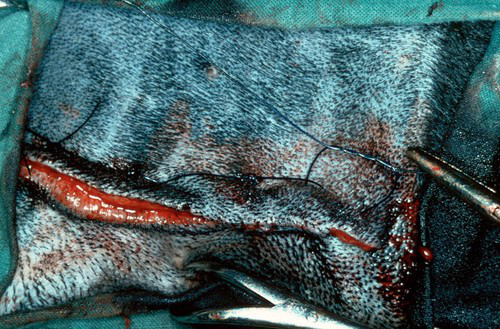

In [118]:
#checking the image
iiif_url = last_result['_source']['state']['derivedData']['thumbnail']['url']
image_url = str(IIIFImageClient().init_from_url(iiif_url).size(width=500))
Image.open(BytesIO(httpx.get(image_url).content))

In [119]:
#Send a query again, searching after the last ID.
response = local_es.search(
    index=os.environ['INDEX_NAME'],
    body={
        "query":{
            "match_all":{}
        },
        "size":20,
        "from":0,
        "search_after": [last_result['_id']],
        "sort":{
            "_id":"asc", #ascending order
        },
    }
)

In [120]:
first_result = response['hits']['hits'][0]
print(first_result['_id'])

a24yqdyw


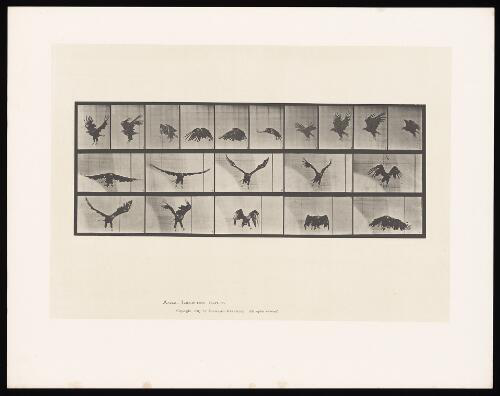

In [121]:
#checking the image
iiif_url = first_result['_source']['state']['derivedData']['thumbnail']['url']
image_url = str(IIIFImageClient().init_from_url(iiif_url).size(width=500))
Image.open(BytesIO(httpx.get(image_url).content))

Check if the image sorted as expected.

a24se2bc


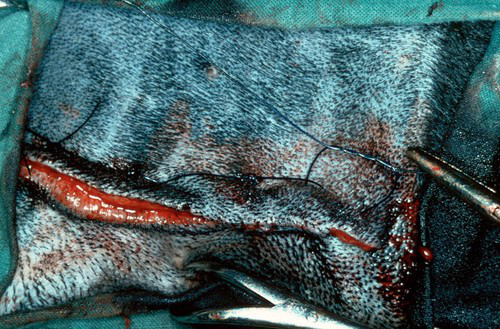

In [122]:
response = local_es.search(
    index=os.environ['INDEX_NAME'],
    body={
        "query":{
            "match_all":{}
        },
        "size":30,
        "from":0,
        "search_after": ['a24yqdyw'],
        "sort":{
            "_id":"desc", #descending order
        },
    }
)

first_result = response['hits']['hits'][0]
print(first_result['_id'])
#checking the image
iiif_url = first_result['_source']['state']['derivedData']['thumbnail']['url']
image_url = str(IIIFImageClient().init_from_url(iiif_url).size(width=500))
Image.open(BytesIO(httpx.get(image_url).content))



In [124]:
print(
    f"Found {response['hits']['total']['value']} "
    f"results in {response['took'] / 1000}s"
)

print()

Found 10000 results in 0.303s



This is weird. Why its still getting 10k results? There should only be 20.

In [134]:
print(len(response['hits']['hits']))
last_result = response['hits']['hits'][20]
print(last_result['_id'])

20


IndexError: list index out of range

The hits does only have 20 elements. I'm confused. Is there any tool that I can use check the response JSON in a human eye frinedly way? (not the leeeeengthy data XD)

Any way, its functionally working. Time to load the process in a function!

## Functions and Script

In [38]:
import os
from elasticsearch import Elasticsearch
from piffle.iiif import IIIFImageClient 
from io import BytesIO
import httpx
from PIL import Image

#connect to ElasticSearch
local_es = Elasticsearch(
    hosts=os.environ['LOCAL_HOST'],
    http_auth=(
        os.environ['LOCAL_USER'],
        os.environ['LOCAL_PASS']
    )
)

#create a new index
local_es.indices.create(
    index='id_url_index', 
    body={
        "settings" : {
            "refresh_interval": -1,
            "number_of_replicas": 0
        },
    }
)
index_name = 'id_url_index'



def Extracting_url_ID(response): #run through each page and get the url
    for doc in response['hits']['hits']:
        ID_url_dict = {'id':doc['_id'],'url':doc['_source']['state']['derivedData']['thumbnail']['url']}
        yield ID_url_dict #this is convenient!

def index_traversing(es_object, size, index_name):
    #run for 1 time and get a last_result
    response = es_object.search(
        index=os.environ['INDEX_NAME'],
        body={
            "query":{"match_all":{}},
            "size":size,
            "from":0,
            "sort":{
                "_id":"asc", #document ID. Unique(I guess)
            },
        }
    )
    #post the first 20 dictionaries
    for ID_url_dict in Extracting_url_ID(response):
        es_object.create(
            index = index_name,
            id = ID_url_dict['id'],
            body = {
                "url": ID_url_dict['url']
            }
        )
        print(ID_url_dict['id'])
    last_result = last_result = response['hits']['hits'][size-1]
    counter = size #just to make the waiting time less painful 
    
    while len(response['hits']['hits'])==size: #get in the loop!
        response = es_object.search(
            index=os.environ['INDEX_NAME'],
            body={
                "query":{"match_all":{}},
                "size":size,
                "from":0,
                "sort":{
                    "_id":"asc", #document ID. Unique(I guess)
                },
                "search_after": [last_result['_id']],
            }
        )
        last_result = response['hits']['hits'][size-1] #update the last ID
        for ID_url_dict in Extracting_url_ID(response): #post the dictionaries
            es_object.create(
                index = index_name,
                id = ID_url_dict['id'],
                body = {
                    "url": ID_url_dict['url']
                }
            )
            print(ID_url_dict['id']) #just to make the waiting time less painful 
        counter+=size
        print(counter)
            
index_traversing(local_es, 20, index_name)


a22a42f2
a22fagm2
a22npg4t
a22tjkrd
a22xudff
a237ah5v
a237azxs
a237hx2d
a238xmmx
a23dnvy7
a23qg4u8
a23r2d7u
a23wckkq
a2464mgy
a2489zy9
a2496x7s
a24e6kvw
a24eg9pm
a24rreyb
a24se2bc
a24yqdyw
a253tp2j
a25c8gmj
a25cqd4b
a25fb78k
a25fw3qb
a25pnw9e
a25tjpuw
a25z2aaj
a267udgz
a26dcedu
a26ewnp8
a26n6gw7
a26xqfpy
a275rndj
a278vmh8
a27j3jwz
a27pk3xr
a27ssvnv
a27w4c7f
40
a284y2ut
a28753n3
a28appce
a28av9sm
a28bm7r5
a28kbxhe
a28q75eh
a292ganx
a294nc7x
a29d3sa6
a29kgmz9
a29shwtk
a29su4ad
a2adgt9w
a2aeu4qb
a2af92ye
a2aq6ze3
a2aus35f
a2aus7z3
a2aym33d
60
a2b87qxp
a2b8fs6q
a2bed3ad
a2bk4kkd
a2bmfnxr
a2bnk5c9
a2bv4a5y
a2bv859u
a2c24mme
a2c344h9
a2c4yfkt
a2c86g7f
a2ce3qkt
a2cgp5kx
a2cjqfqy
a2cuumt2
a2cuznjb
a2d2aec6
a2d2yw3y
a2da6v4w
80
a2dmxm3x
a2dqz2ak
a2dvxw3b
a2e5ff9v
a2emcr7n
a2f34f74
a2fbd724


KeyboardInterrupt: 

I need to stop this! XXXXXXD

In [37]:
local_es.indices.delete(
    index='id_url_index', 
)

{'acknowledged': True}

In [55]:
import os
from elasticsearch import Elasticsearch
from piffle.iiif import IIIFImageClient 
from io import BytesIO
import httpx
from PIL import Image

#connect to ElasticSearch
local_es = Elasticsearch(
    hosts=os.environ['LOCAL_HOST'],
    http_auth=(
        os.environ['LOCAL_USER'],
        os.environ['LOCAL_PASS']
    )
)

#create a new index
local_es.indices.create(
    index='id_url_index_2', 
    body={
        "settings" : {
            "refresh_interval": -1,
            "number_of_replicas": 0
        },
    }
)
index_name = 'id_url_index_2'



def Extracting_url_ID(response): #run through each page and get the url
    for doc in response['hits']['hits']:
        ID_url_dict = {'id':doc['_id'],'url':doc['url']}
        yield ID_url_dict #this is convenient!

def index_traversing(es_object, size, index_name):
    #run for 1 time and get a last_result
    response = es_object.search(
        index='id_url_index',
        body={
            "query":{"match_all":{}},
            "size":size,
            "from":0,
            "sort":{
                "_id":"asc", #document ID. Unique(I guess)
            },
        }
    )
    #post the first 20 dictionaries
    for ID_url_dict in Extracting_url_ID(response):
        es_object.create(
            index = index_name,
            id = ID_url_dict['id'],
            body = {
                "url": ID_url_dict['url']
            }
        )
        print(ID_url_dict['id'])
    last_result = last_result = response['hits']['hits'][size-1]
    counter = size #just to make the waiting time less painful 
    
    while len(response['hits']['hits'])==size: #get in the loop!
        response = es_object.search(
            index='id_url_index',
            body={
                "query":{"match_all":{}},
                "size":size,
                "from":0,
                "sort":{
                    "_id":"asc", #document ID. Unique(I guess)
                },
                "search_after": [last_result['_id']],
            }
        )
        last_result = response['hits']['hits'][size-1] #update the last ID
        for ID_url_dict in Extracting_url_ID(response): #post the dictionaries
            es_object.create(
                index = index_name,
                id = ID_url_dict['id'],
                body = {
                    "url": ID_url_dict['url']
                }
            )
            print(ID_url_dict['id']) #just to make the waiting time less painful 
        counter+=size
        print(counter)
            
index_traversing(local_es, 20, index_name)


IndexError: list index out of range

In [41]:
local_es.indices.delete(
    index='id_url_index_2'
)

{'acknowledged': True}

In [64]:
import os
from elasticsearch import Elasticsearch
from piffle.iiif import IIIFImageClient 
from io import BytesIO
import httpx
from PIL import Image

#connect to ElasticSearch
local_es = Elasticsearch(
    hosts=os.environ['LOCAL_HOST'],
    http_auth=(
        os.environ['LOCAL_USER'],
        os.environ['LOCAL_PASS']
    )
)
response = local_es.search(
    index='id_url_index',
    body={
        "query":{
            "match_all":{}
        },
        "size":20,
        "from":0,
    }
)

response




{'took': 0,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

In [63]:
response = local_es.get(
    index = 'id_url_index',
    id = 'a2ce3qkt',
)
response

{'_index': 'id_url_index',
 '_type': '_doc',
 '_id': 'a2ce3qkt',
 '_version': 1,
 '_seq_no': 72,
 '_primary_term': 1,
 'found': True,
 '_source': {'url': 'https://iiif.wellcomecollection.org/image/L0012150/info.json'}}

In [50]:
response = local_es.count(
        index='id_url_index',
    )

response

{'count': 0,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}